In [ ]:
# ===============================
# Mount Google Drive
# ===============================
from google.colab import drive
import os

drive.mount('/content/drive')

# ===============================
# Define Paths
# ===============================
# Main dataset directory in Drive
DATA_DIR = "/content/drive/MyDrive/cervical_data"

# Images and masks subfolders
images = os.path.join(DATA_DIR, "png")     # input images
masks  = os.path.join(DATA_DIR, "edge")    # edge/mask images

# Check if directories exist
print("Images dir exists:", os.path.exists(images))
print("Masks dir exists:", os.path.exists(masks))

# ===============================
# Checkpoints save folder
# ===============================
OUTPUT_DIR = "/content/drive/MyDrive/cervical_checkpoints"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Checkpoints will be saved to:", OUTPUT_DIR)

# ===============================
# Preview data
# ===============================
# Let's print a few files just to check
print("Sample images:", os.listdir(images)[:5])
print("Sample masks:", os.listdir(masks)[:5])


Mounted at /content/drive
Images dir exists: True
Masks dir exists: True
Checkpoints will be saved to: /content/drive/MyDrive/cervical_checkpoints
Sample images: ['00004.png', '00033.png', '00029.png', '00058.png', '00016.png']
Sample masks: ['00018_edge.png', '00048_edge.png', '00102_edge.png', '00186_edge.png', '00054_edge.png']


# Vanilla Unet arch

In [ ]:
# ===============================
# Install & Imports
# ===============================
!pip install albumentations==1.4.3 --quiet

import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import drive

# ===============================
# Google Drive setup
# ===============================
drive.mount('/content/drive')

DATA_DIR = "/content/drive/MyDrive/cervical_data"
images = os.path.join(DATA_DIR, "png")     # input images
masks  = os.path.join(DATA_DIR, "edge")    # mask images

OUTPUT_DIR = "/content/drive/MyDrive/cervical_checkpoints"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Images dir exists:", os.path.exists(images))
print("Masks dir exists:", os.path.exists(masks))
print("Checkpoints will be saved to:", OUTPUT_DIR)

# ===============================
# Dataset Class
# ===============================
class CervicalDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images = sorted(os.listdir(images_dir))
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_filename = self.images[idx]
        mask_filename = img_filename.replace(".png", "_edge.png")

        img_path = os.path.join(self.images_dir, img_filename)
        mask_path = os.path.join(self.masks_dir, mask_filename)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask not found: {mask_path}")

        mask = (mask > 127).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0)
        else:
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask

# ===============================
# Data Augmentation
# ===============================
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, shift_limit=0.1, p=0.5),
    A.GaussianBlur(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])

train_dataset = CervicalDataset(images, masks, transform=train_transform)
val_dataset   = CervicalDataset(images, masks, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

# ===============================
# U-Net from scratch
# ===============================
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)

        d2 = self.down2(p1)
        p2 = self.pool2(d2)

        d3 = self.down3(p2)
        p3 = self.pool3(d3)

        d4 = self.down4(p3)
        p4 = self.pool4(d4)

        bn = self.bottleneck(p4)

        u4 = self.up4(bn)
        u4 = torch.cat([u4, d4], dim=1)
        u4 = self.conv4(u4)

        u3 = self.up3(u4)
        u3 = torch.cat([u3, d3], dim=1)
        u3 = self.conv3(u3)

        u2 = self.up2(u3)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.conv2(u2)

        u1 = self.up1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.conv1(u1)

        return self.final(u1)

# ===============================
# Training setup
# ===============================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(DEVICE)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_fn(loader, model, optimizer, loss_fn, device):
    model.train()
    epoch_loss = 0
    for imgs, masks in tqdm(loader, leave=False):
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        preds = model(imgs)
        loss = loss_fn(preds, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def eval_fn(loader, model, loss_fn, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = loss_fn(preds, masks)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

# ===============================
# Training Loop
# ===============================
EPOCHS = 20
best_loss = float("inf")

for epoch in range(1, EPOCHS+1):
    train_loss = train_fn(train_loader, model, optimizer, loss_fn, DEVICE)
    val_loss   = eval_fn(val_loader, model, loss_fn, DEVICE)

    print(f"Epoch [{epoch}/{EPOCHS}]  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "unet_basic_best.pth"))
        print("✅ Model saved!")

# ===============================
# Visualization
# ===============================
def visualize_sample(loader, model, device, num_samples=3):
    model.eval()
    imgs, masks = next(iter(loader))
    imgs, masks = imgs.to(device), masks.to(device)
    preds = torch.sigmoid(model(imgs))
    preds = (preds > 0.5).float()

    for i in range(num_samples):
        fig, axs = plt.subplots(1,3, figsize=(12,4))
        axs[0].imshow(imgs[i].permute(1,2,0).cpu().numpy())
        axs[0].set_title("Image")
        axs[1].imshow(masks[i][0].cpu().numpy(), cmap='gray')
        axs[1].set_title("Ground Truth")
        axs[2].imshow(preds[i][0].cpu().numpy(), cmap='gray')
        axs[2].set_title("Prediction")
        plt.show()

# Show few predictions
visualize_sample(val_loader, model, DEVICE)


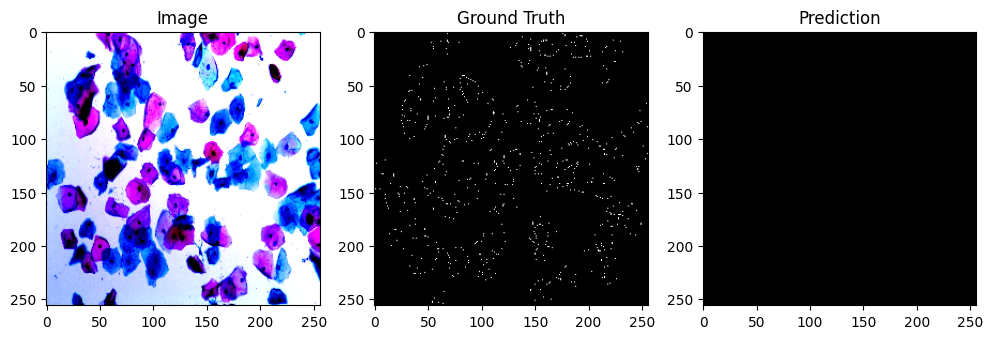

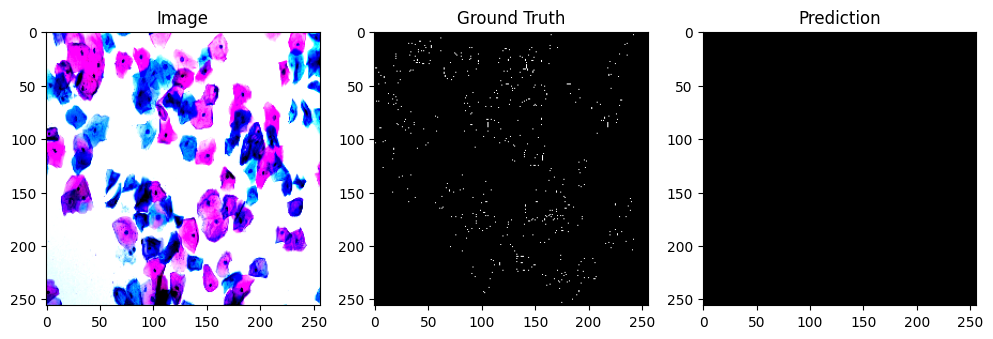

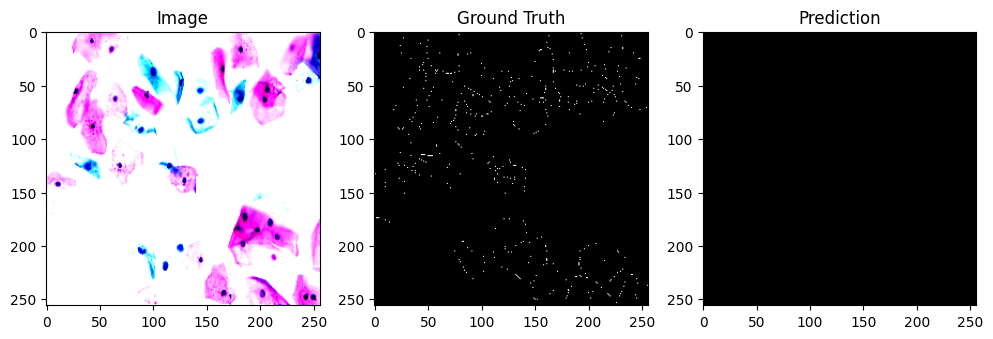

In [ ]:
def visualize_sample(loader, model, device, num_samples=3):
    model.eval()
    imgs, masks = next(iter(loader))
    imgs, masks = imgs.to(device), masks.to(device)
    preds = torch.sigmoid(model(imgs))
    preds = (preds > 0.5).float()

    for i in range(num_samples):
        fig, axs = plt.subplots(1,3, figsize=(12,4))
        axs[0].imshow(imgs[i].permute(1,2,0).cpu().numpy())
        axs[0].set_title("Image")
        axs[1].imshow(masks[i][0].cpu().numpy(), cmap='gray')
        axs[1].set_title("Ground Truth")
        axs[2].imshow(preds[i][0].cpu().numpy(), cmap='gray')
        axs[2].set_title("Prediction")
        plt.show()

# Show few predictions
visualize_sample(val_loader, model, DEVICE)

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

# Make sure model is loaded
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, "unet_basic_best.pth"), map_location=DEVICE))
model.eval()

def visualize_contour_predictions(loader, model, device, num_samples=5):
    model.eval()
    imgs, masks = next(iter(loader))
    imgs, masks = imgs.to(device), masks.to(device)

    with torch.no_grad():
        preds = torch.sigmoid(model(imgs))
        preds = (preds > 0.5).float()

    for i in range(num_samples):
        # Convert tensors to NumPy arrays
        img  = (imgs[i].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
        mask = (masks[i][0].cpu().numpy() * 255).astype(np.uint8)
        pred = (preds[i][0].cpu().numpy() * 255).astype(np.uint8)

        # Convert to BGR for cv2 drawing
        overlay = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # Find contours for ground truth and predictions
        gt_contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        pred_contours, _ = cv2.findContours(pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw contours
        cv2.drawContours(overlay, gt_contours, -1, (255, 0, 0), 2)   # Blue → Ground Truth
        cv2.drawContours(overlay, pred_contours, -1, (0, 255, 0), 2) # Green → Prediction

        # Convert back to RGB for display
        overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

        # Plot results
        plt.figure(figsize=(6,6))
        plt.imshow(overlay_rgb)
        plt.title(f"Sample {i+1} — Blue: Ground Truth, Green: Prediction")
        plt.axis("off")
        plt.show()

# Run the visualization
visualize_contour_predictions(val_loader, model, DEVICE, num_samples=5)


# Watershed Algo

In [ ]:
import scipy.ndimage as ndi

def postprocess_watershed(pred_mask):
    """
    pred_mask: numpy array (H, W), values {0,1}
    Returns: separated mask (each object labeled)
    """
    # Step 1: Clean mask
    kernel = np.ones((3,3), np.uint8)
    cleaned = cv2.morphologyEx(pred_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)

    # Step 2: Distance transform (for nuclei centers)
    dist = cv2.distanceTransform(cleaned, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist, 0.5*dist.max(), 1, 0)
    sure_fg = np.uint8(sure_fg)

    # Step 3: Find unknown regions
    sure_bg = cv2.dilate(cleaned, kernel, iterations=3)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Step 4: Marker labelling
    num_markers, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown==1] = 0

    # Step 5: Apply watershed
    color_img = cv2.cvtColor((cleaned*255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    cv2.watershed(color_img, markers)

    separated = (markers > 1).astype(np.uint8)
    return separated, markers


In [ ]:
def visualize_with_postprocessing(loader, model, device, num_samples=3):
    model.eval()
    imgs, masks = next(iter(loader))
    imgs, masks = imgs.to(device), masks.to(device)
    preds = torch.sigmoid(model(imgs))
    preds = (preds > 0.5).float()

    for i in range(num_samples):
        img_np = imgs[i].permute(1,2,0).cpu().numpy()
        gt_mask = masks[i][0].cpu().numpy()
        pred_mask = preds[i][0].cpu().numpy()

        # Apply post-processing
        separated, markers = postprocess_watershed(pred_mask)

        fig, axs = plt.subplots(1,4, figsize=(16,4))
        axs[0].imshow(img_np)
        axs[0].set_title("Image")
        axs[1].imshow(gt_mask, cmap='gray')
        axs[1].set_title("Ground Truth")
        axs[2].imshow(pred_mask, cmap='gray')
        axs[2].set_title("Raw Prediction")
        axs[3].imshow(markers, cmap='nipy_spectral')
        axs[3].set_title("Post-processed (Watershed)")
        plt.show()

# Run with post-processing
visualize_with_postprocessing(val_loader, model, DEVICE)


## Pre trained u net architecture (Transfer Learning)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 118MB/s]


Epoch [1/20]  Train Loss: 0.9786  Val Loss: 0.9734
✅ Model saved!


Epoch [2/20]  Train Loss: 0.9704  Val Loss: 0.9672
✅ Model saved!


Epoch [3/20]  Train Loss: 0.9615  Val Loss: 0.9563
✅ Model saved!


Epoch [4/20]  Train Loss: 0.9499  Val Loss: 0.9419
✅ Model saved!


Epoch [5/20]  Train Loss: 0.9344  Val Loss: 0.9232
✅ Model saved!


Epoch [6/20]  Train Loss: 0.9182  Val Loss: 0.9066
✅ Model saved!


Epoch [7/20]  Train Loss: 0.9061  Val Loss: 0.8920
✅ Model saved!


Epoch [8/20]  Train Loss: 0.8983  Val Loss: 0.8926


Epoch [9/20]  Train Loss: 0.8930  Val Loss: 0.8824
✅ Model saved!


Epoch [10/20]  Train Loss: 0.8896  Val Loss: 0.8777
✅ Model saved!


Epoch [11/20]  Train Loss: 0.8854  Val Loss: 0.8750
✅ Model saved!


Epoch [12/20]  Train Loss: 0.8846  Val Loss: 0.8716
✅ Model saved!


Epoch [13/20]  Train Loss: 0.8824  Val Loss: 0.8696
✅ Model saved!


Epoch [14/20]  Train Loss: 0.8811  Val Loss: 0.8680
✅ Model saved!


Epoch [15/20]  Train Loss: 0.8800  Val Loss: 0.8676
✅ Model saved!


Epoch [16/20]  Train Loss: 0.8788  Val Loss: 0.8683


Epoch [17/20]  Train Loss: 0.8771  Val Loss: 0.8669
✅ Model saved!


Epoch [18/20]  Train Loss: 0.8762  Val Loss: 0.8687


Epoch [19/20]  Train Loss: 0.8757  Val Loss: 0.8643
✅ Model saved!


Epoch [20/20]  Train Loss: 0.8752  Val Loss: 0.8695


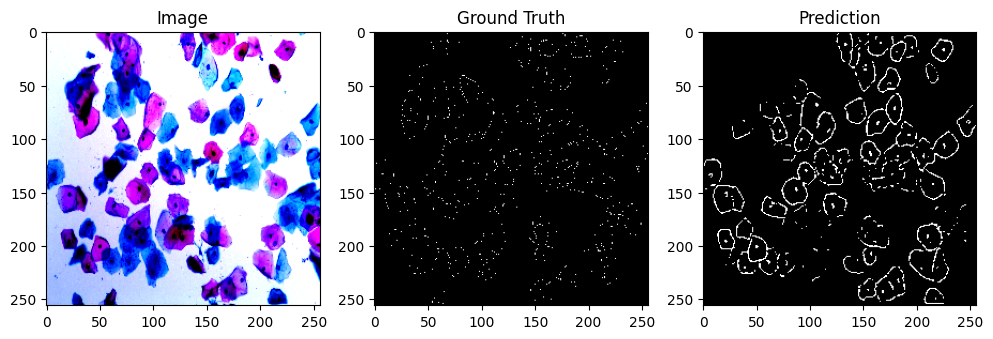

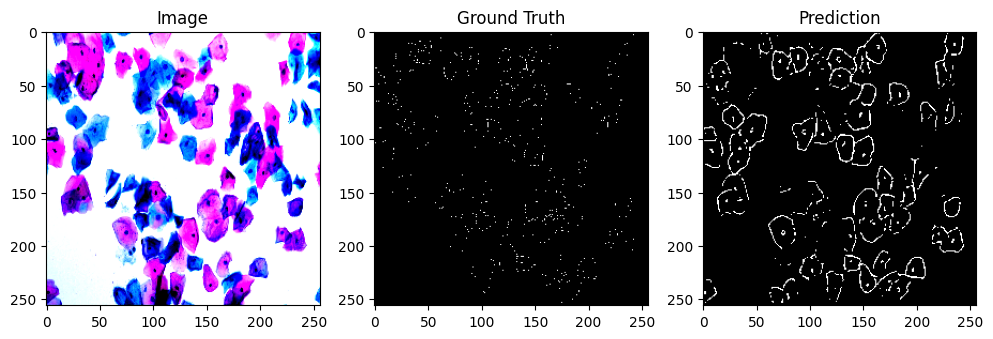

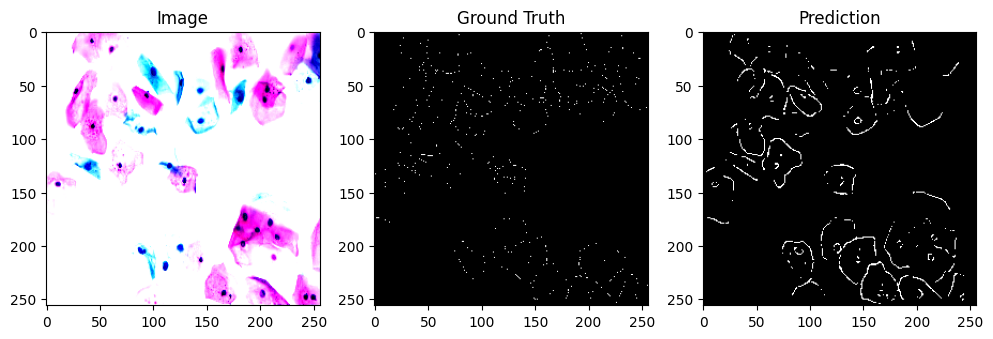

In [ ]:
# ===============================
# Install & Imports
# ===============================
!pip install albumentations==1.4.3 segmentation-models-pytorch==0.3.3 --quiet

import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

# ===============================
# Dataset Class
# ===============================
# ===============================
# Dataset Class (image ↔ mask matching)
# ===============================
class CervicalDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_filename = self.images[idx]
        mask_filename = img_filename.replace(".png", "_edge.png")

        img_path = os.path.join(self.images_dir, img_filename)
        mask_path = os.path.join(self.masks_dir, mask_filename)

        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask (grayscale)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask not found: {mask_path}")

        # Normalize mask to 0/1
        mask = (mask > 127).astype(np.float32)

        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0)  # add channel dim
        else:
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask


# ===============================
# Data Augmentation
# ===============================
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, shift_limit=0.1, p=0.5),
    A.GaussianBlur(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])

# ===============================
# Dataset & DataLoader
# ===============================
train_dataset = CervicalDataset(images, masks, transform=train_transform)
val_dataset   = CervicalDataset(images, masks, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

# ===============================
# U-Net Model (binary segmentation)
# ===============================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = smp.Unet(
    encoder_name="resnet34",        # backbone
    encoder_weights="imagenet",     # pre-trained encoder
    in_channels=3,                  # RGB images
    classes=1,                      # binary segmentation
).to(DEVICE)

# Loss & Optimizer
loss_fn = smp.losses.DiceLoss(mode='binary')
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ===============================
# Training Loop
# ===============================
def train_fn(loader, model, optimizer, loss_fn, device):
    model.train()
    epoch_loss = 0
    for imgs, masks in tqdm(loader, leave=False):
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        preds = model(imgs)
        loss = loss_fn(preds, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def eval_fn(loader, model, loss_fn, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = loss_fn(preds, masks)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

# ===============================
# Run Training
# ===============================
EPOCHS = 20
best_loss = float("inf")

for epoch in range(1, EPOCHS+1):
    train_loss = train_fn(train_loader, model, optimizer, loss_fn, DEVICE)
    val_loss   = eval_fn(val_loader, model, loss_fn, DEVICE)

    print(f"Epoch [{epoch}/{EPOCHS}]  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "unet_best.pth"))
        print("✅ Model saved!")

# ===============================
# Visualization Function
# ===============================
def visualize_sample(loader, model, device, num_samples=3):
    model.eval()
    imgs, masks = next(iter(loader))
    imgs, masks = imgs.to(device), masks.to(device)
    preds = torch.sigmoid(model(imgs))
    preds = (preds > 0.5).float()

    for i in range(num_samples):
        fig, axs = plt.subplots(1,3, figsize=(12,4))
        axs[0].imshow(imgs[i].permute(1,2,0).cpu().numpy())
        axs[0].set_title("Image")
        axs[1].imshow(masks[i][0].cpu().numpy(), cmap='gray')
        axs[1].set_title("Ground Truth")
        axs[2].imshow(preds[i][0].cpu().numpy(), cmap='gray')
        axs[2].set_title("Prediction")
        plt.show()

# After training:
visualize_sample(val_loader, model, DEVICE)


# new pretrained unetPlusPlus

In [ ]:
# Colab-ready improved cervical segmentation training script
# Run in Colab: paste into a cell and run.
# Make sure your images and masks are organized and filenames align (mask naming handled below).

# ===============================
# Install & Imports
# ===============================
!pip install albumentations==1.4.3 segmentation-models-pytorch==0.3.3 --quiet


import os
import random
from pathlib import Path
from glob import glob
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

# ===============================
# Config / Paths / Hyperparams
# ===============================
# Edit these paths as needed
IMAGES_DIR = "/content/drive/MyDrive/cervical_data/png"    # path to folder with input RGB images
MASKS_DIR  = "/content/drive/MyDrive/cervical_data/edge"     # path to folder with corresponding mask files
OUTPUT_DIR = "/content/drive/MyDrive/cervical_data/"    # where to save best model + logs

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Hyperparameters
CFG = {
    "seed": 42,
    "img_size": 256,
    "batch_size": 8,
    "num_workers": 2,
    "epochs": 30,
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "encoder": "efficientnet-b3",     # try efficientnet-b3, resnet50, se_resnext50_32x4d
    "architecture": "unetplusplus",   # 'unet', 'unetplusplus', 'deeplabv3+'
    "threshold": 0.5,
    "mask_suffix": "_edge.png"        # change if your mask naming differs
}

print("Device:", CFG["device"])

# ===============================
# Utilities
# ===============================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(CFG["seed"])

# ===============================
# Dataset
# ===============================
class CervicalDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, mask_suffix="_edge.png"):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        self.image_files = sorted([p for p in self.images_dir.iterdir() if p.suffix.lower() in [".png", ".jpg", ".jpeg"]])
        self.transform = transform
        self.mask_suffix = mask_suffix

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img_name = img_path.stem
        # mask filename convention: image.png -> image_edge.png (adjust via mask_suffix)
        mask_name = img_name + self.mask_suffix
        mask_path = self.masks_dir / mask_name
        if not mask_path.exists():
            # attempt common alternative: same name as image
            mask_path_alt = self.masks_dir / (img_name + ".png")
            if mask_path_alt.exists():
                mask_path = mask_path_alt
            else:
                raise FileNotFoundError(f"Mask not found for {img_path.name}: tried {mask_path} and {mask_path_alt}")

        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Failed to read mask: {mask_path}")

        # make mask binary
        mask = (mask > 127).astype("float32")

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"].unsqueeze(0).float()  # (1, H, W)
        else:
            image = torch.tensor(image, dtype=torch.float32).permute(2,0,1) / 255.0
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask

# ===============================
# Augmentations
# ===============================
# ===============================
# Augmentations (✅ modern & compatible with Albumentations>=1.3)
# ===============================
# ===============================
# Fixed Augmentations (keep final size consistent)
# ===============================
train_transform = A.Compose([
    # start by resizing so very small/huge images are normalized
    A.Resize(CFG["img_size"], CFG["img_size"]),

    # spatial augmentations that keep size (or crop then resize back)
    A.RandomCrop(int(CFG["img_size"] * 0.9), int(CFG["img_size"] * 0.9), p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.08, rotate_limit=20, p=0.5),

    A.OneOf([
        A.Sharpen(p=0.5),
        A.GaussNoise(p=0.5),
        A.MotionBlur(p=0.5),
    ], p=0.3),

    A.OneOf([
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.OpticalDistortion(distort_limit=0.5, shift_limit=0.05, p=0.5),
        A.PiecewiseAffine(scale=(0.01, 0.03), p=0.5),
    ], p=0.3),

    A.CLAHE(p=0.2),
    A.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.02, p=0.5),

    # MAKE SURE final output is the desired size:
    A.Resize(CFG["img_size"], CFG["img_size"]),

    # normalization + convert to torch tensor (must be last)
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(CFG["img_size"], CFG["img_size"]),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])



# ===============================
# Prepare Datasets & Loaders
# ===============================
# Simple split: use first 80% as train, last 20% as val (if you don't have explicit split)
all_images = sorted([p for p in Path(IMAGES_DIR).iterdir() if p.suffix.lower() in [".png", ".jpg", ".jpeg"]])
n_total = len(all_images)
if n_total == 0:
    raise RuntimeError(f"No images found in {IMAGES_DIR}. Please upload images.")

split_idx = int(n_total * 0.8)
train_imgs = all_images[:split_idx]
val_imgs   = all_images[split_idx:]

# Instead of copying, we'll create datasets that internally use the folder listing — but to ensure
# deterministic split we create lists of filenames and filter dataset lists.
def filtered_dataset(image_paths, transforms, mask_suffix):
    class FilteredDataset(CervicalDataset):
        def __init__(self, image_paths, masks_dir, transform, mask_suffix):
            self.image_files = image_paths
            self.masks_dir = Path(masks_dir)
            self.transform = transform
            self.mask_suffix = mask_suffix
        def __len__(self):
            return len(self.image_files)
        def __getitem__(self, idx):
            img_path = self.image_files[idx]
            img_name = img_path.stem
            mask_name = img_name + self.mask_suffix
            mask_path = self.masks_dir / mask_name
            if not mask_path.exists():
                mask_path_alt = self.masks_dir / (img_name + ".png")
                if mask_path_alt.exists():
                    mask_path = mask_path_alt
                else:
                    raise FileNotFoundError(f"Mask not found for {img_path.name}: tried {mask_path} and {mask_path_alt}")

            image = cv2.imread(str(img_path))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
            mask = (mask > 127).astype("float32")
            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented["image"]
                mask = augmented["mask"].unsqueeze(0).float()
            else:
                image = torch.tensor(image, dtype=torch.float32).permute(2,0,1) / 255.0
                mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
            return image, mask

    return FilteredDataset(image_paths, MASKS_DIR, transforms, CFG["mask_suffix"])

train_dataset = filtered_dataset(train_imgs, train_transform, CFG["mask_suffix"])
val_dataset   = filtered_dataset(val_imgs, val_transform, CFG["mask_suffix"])

train_loader = DataLoader(train_dataset, batch_size=CFG["batch_size"], shuffle=True, num_workers=CFG["num_workers"], pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=CFG["batch_size"], shuffle=False, num_workers=CFG["num_workers"], pin_memory=True)

print(f"Train samples: {len(train_dataset)}  Val samples: {len(val_dataset)}")

# ===============================
# Model
# ===============================
ENCODER = CFG["encoder"]
if CFG["architecture"].lower() == "unetplusplus":
    model = smp.UnetPlusPlus(
        encoder_name=ENCODER,
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
    )
elif CFG["architecture"].lower() == "deeplabv3+" or CFG["architecture"].lower() == "deeplab":
    model = smp.DeepLabV3Plus(
        encoder_name=ENCODER,
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
    )
else:
    model = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
    )

model = model.to(CFG["device"])

# ===============================
# Loss, Optimizer, Scheduler
# ===============================
# Use BCEWithLogits and Dice combined (logits input)
bce_loss = nn.BCEWithLogitsLoss()
dice_loss = smp.losses.DiceLoss(mode='binary')  # expects logits
def combined_loss(y_pred, y_true):
    # y_pred: logits (B,1,H,W), y_true: (B,1,H,W)
    bce = bce_loss(y_pred, y_true)
    d  = dice_loss(y_pred, y_true)
    return 0.5 * bce + 0.5 * d

optimizer = optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# ===============================
# Metrics (Dice & IoU)
# ===============================
def logits_to_probs(logits):
    return torch.sigmoid(logits)

def dice_coef_from_logits(logits, targets, thr=0.5, eps=1e-6):
    probs = logits_to_probs(logits)
    preds = (probs > thr).float()
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    dice = (2*intersection + eps) / (union + eps)
    return dice.mean().item()

def iou_from_logits(logits, targets, thr=0.5, eps=1e-6):
    probs = logits_to_probs(logits)
    preds = (probs > thr).float()
    inter = (preds * targets).sum(dim=(1,2,3))
    union = (preds + targets - preds*targets).sum(dim=(1,2,3))
    iou = (inter + eps) / (union + eps)
    return iou.mean().item()

# ===============================
# Training & Eval loops (mixed precision)
# ===============================
scaler = torch.cuda.amp.GradScaler(enabled=(CFG["device"].startswith("cuda")))

def train_one_epoch(loader, model, optimizer, device):
    model.train()
    running_loss = 0.0
    pbar = tqdm(loader, total=len(loader), desc="Train", leave=False)
    for imgs, masks in pbar:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=(device.startswith("cuda"))):
            outputs = model(imgs)  # logits (B,1,H,W)
            loss = combined_loss(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        pbar.set_postfix(loss=f"{running_loss / (pbar.n + 1):.4f}")
    return running_loss / len(loader)

def validate_one_epoch(loader, model, device):
    model.eval()
    running_loss = 0.0
    dices = []
    ious = []
    with torch.no_grad():
        pbar = tqdm(loader, total=len(loader), desc="Valid", leave=False)
        for imgs, masks in pbar:
            imgs = imgs.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)

            outputs = model(imgs)
            loss = combined_loss(outputs, masks)

            running_loss += loss.item()
            dices.append(dice_coef_from_logits(outputs, masks, thr=CFG["threshold"]))
            ious.append(iou_from_logits(outputs, masks, thr=CFG["threshold"]))

            pbar.set_postfix(loss=f"{running_loss / (pbar.n + 1):.4f}", dice=f"{np.mean(dices):.4f}")
    return running_loss / len(loader), float(np.mean(dices)), float(np.mean(ious))

# ===============================
# Save & Load helpers
# ===============================
def save_checkpoint(state, filename):
    torch.save(state, filename)

# ===============================
# Visualization helper
# ===============================
def visualize_batch(loader, model, device, num_samples=3):
    model.eval()
    imgs, masks = next(iter(loader))
    imgs = imgs.to(device)
    masks = masks.to(device)
    with torch.no_grad():
        outputs = model(imgs)
        probs = torch.sigmoid(outputs)
        preds = (probs > CFG["threshold"]).float()

    for i in range(min(num_samples, imgs.shape[0])):
        img = imgs[i].permute(1,2,0).cpu().numpy()
        img = (img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]))  # unnormalize
        img = np.clip(img, 0, 1)

        gt = masks[i][0].cpu().numpy()
        pr = preds[i][0].cpu().numpy()
        overlay = img.copy()
        # Create red overlay for prediction and green for ground truth difference
        overlay_mask = np.zeros_like(img)
        overlay_mask[pr == 1] = [1, 0, 0] # red
        # Blend
        blended = (img * 0.6 + overlay_mask * 0.4)
        fig, axs = plt.subplots(1,3, figsize=(12,4))
        axs[0].imshow(img); axs[0].set_title("Image"); axs[0].axis("off")
        axs[1].imshow(gt, cmap="gray"); axs[1].set_title("Ground Truth"); axs[1].axis("off")
        axs[2].imshow(blended); axs[2].set_title("Prediction Overlay"); axs[2].axis("off")
        plt.show()

# ===============================
# Training Run
# ===============================
best_val_loss = float("inf")
best_dice = 0.0

for epoch in range(1, CFG["epochs"] + 1):
    print(f"\nEpoch {epoch}/{CFG['epochs']} ----------------")
    train_loss = train_one_epoch(train_loader, model, optimizer, CFG["device"])
    val_loss, val_dice, val_iou = validate_one_epoch(val_loader, model, CFG["device"])

    # scheduler step (ReduceLROnPlateau)
    scheduler.step(val_loss)

    print(f"Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}  Val Dice: {val_dice:.4f}  Val IoU: {val_iou:.4f}")

    # Save best by val_loss and also by val_dice
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_path = os.path.join(OUTPUT_DIR, "best_by_val_loss.pth")
        print("Saving best_by_val_loss:", save_path)
        save_checkpoint({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "val_loss": val_loss,
            "val_dice": val_dice
        }, save_path)

    if val_dice > best_dice:
        best_dice = val_dice
        save_path = os.path.join(OUTPUT_DIR, "best_by_val_dice.pth")
        print("Saving best_by_val_dice:", save_path)
        save_checkpoint({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "val_loss": val_loss,
            "val_dice": val_dice
        }, save_path)

    # Quick visualization every few epochs
    if epoch % 5 == 0 or epoch == 1:
        visualize_batch(val_loader, model, CFG["device"], num_samples=3)

print("Training finished. Best val loss:", best_val_loss, " Best dice:", best_dice)
print("Saved models in", OUTPUT_DIR)


In [ ]:
# ===============================
# 🔍 Visualize Prediction on Uploaded Image
# ===============================
from google.colab import files
from PIL import Image

def predict_and_visualize(model, image_path, device, cfg):
    model.eval()
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    orig = image.copy()
    transform = A.Compose([
        A.Resize(cfg["img_size"], cfg["img_size"]),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2(),
    ])
    aug = transform(image=image)
    img_tensor = aug["image"].unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        output = model(img_tensor)
        prob = torch.sigmoid(output)[0,0].cpu().numpy()
        pred_mask = (prob > cfg["threshold"]).astype(np.uint8)

    # Resize mask back to original image size
    pred_mask_resized = cv2.resize(pred_mask, (orig.shape[1], orig.shape[0]))

    # Overlay (red = predicted region)
    overlay = orig.copy()
    overlay[pred_mask_resized == 1] = [255, 0, 0]
    blended = cv2.addWeighted(orig, 0.6, overlay, 0.4, 0)

    # Plot results
    plt.figure(figsize=(14,5))
    plt.subplot(1,3,1)
    plt.imshow(orig)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(pred_mask_resized, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(blended)
    plt.title("Overlay Result")
    plt.axis("off")
    plt.show()

# ===============================
# 📤 Upload image and run prediction
# ===============================
uploaded = files.upload()
for filename in uploaded.keys():
    image_path = f"/content/{filename}"
    print(f"Running prediction on {filename} ...")
    predict_and_visualize(model, image_path, CFG["device"], CFG)


In [ ]:
# ===============================
# 0️⃣ Imports (after training Detectron2 model)
# ===============================
import os, random, cv2, numpy as np
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# ===============================
# 1️⃣ Setup Paths & Predictor
# ===============================
OUTPUT_DIR = "/content/drive/MyDrive/cervical_checkpoints"
IMG_DIR = "/content/drive/MyDrive/cervical_data/png"

# Load metadata
paps_metadata = MetadataCatalog.get("papsmear_train")

cfg.MODEL.WEIGHTS = os.path.join(OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

# ===============================
# 2️⃣ Utility: Separate Overlapping Cells
# ===============================
def separate_cells_from_mask(mask):
    """
    Input: binary mask (uint8)
    Output: list of individual cell masks (uint8)
    """
    separated_masks = []

    # Step 1: Remove small noise
    kernel = np.ones((3,3), np.uint8)
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    # Step 2: Find contours
    contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if w>10 and h>10:  # ignore tiny objects
            # Extract individual cell mask
            cell_mask = np.zeros_like(mask, dtype=np.uint8)
            cv2.drawContours(cell_mask, [cnt], -1, 255, -1)  # fill contour
            separated_masks.append((cell_mask, (x,y,w,h)))

    return separated_masks

# ===============================
# 3️⃣ Process a Sample Image
# ===============================
sample_img_file = random.choice(os.listdir(IMG_DIR))
img_path = os.path.join(IMG_DIR, sample_img_file)
im = cv2.imread(img_path)
outputs = predictor(im)

# Visualize predictions
v = Visualizer(im[:, :, ::-1], metadata=paps_metadata, scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(8,8))
plt.imshow(out.get_image())
plt.axis("off")
plt.show()

# ===============================
# 4️⃣ Extract & Separate Cells
# ===============================
cell_patches = []

masks = outputs["instances"].pred_masks.cpu().numpy()
for mask in masks:
    mask_uint8 = (mask*255).astype(np.uint8)

    # Separate overlapping cells
    separated = separate_cells_from_mask(mask_uint8)

    for cell_mask, (x,y,w,h) in separated:
        patch = cv2.bitwise_and(im, im, mask=cell_mask)
        patch = patch[y:y+h, x:x+w]
        cell_patches.append(patch)

print(f"Extracted {len(cell_patches)} cells from {sample_img_file}")

# ===============================
# 5️⃣ Save Individual Cells
# ===============================
CELL_SAVE_DIR = os.path.join(OUTPUT_DIR, "cells")
os.makedirs(CELL_SAVE_DIR, exist_ok=True)

for i, patch in enumerate(cell_patches):
    cv2.imwrite(os.path.join(CELL_SAVE_DIR, f"{sample_img_file.replace('.png','')}_cell{i}.png"), patch)

# ===============================
# 6️⃣ Optional: Grid Visualization
# ===============================
cell_size = 64
cols = 8
rows = int(np.ceil(len(cell_patches)/cols))
grid_img = np.zeros((rows*cell_size, cols*cell_size, 3), np.uint8)

for i, patch in enumerate(cell_patches):
    r = i // cols
    c = i % cols
    if patch.shape[0]>0 and patch.shape[1]>0:
        resized_patch = cv2.resize(patch, (cell_size, cell_size))
        grid_img[r*cell_size:(r+1)*cell_size, c*cell_size:(c+1)*cell_size] = resized_patch

plt.figure(figsize=(12,6))
plt.title("Cells Grid")
plt.imshow(cv2.cvtColor(grid_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
